# SOM analysis of NPJ using weights for Hawaiian rainfall disturbance days

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import statistics

In [2]:
# Load in ERA5 ua250 data 1981-2010; wet season only (Nov-Apr)
da = xr.open_dataset('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/era5_day_ua250_1981-2010.nc')

In [3]:
# Select years 1990-2010
da = da.sel(time=slice('1990-01-01', '2010-12-31'))

In [4]:
# Calculate monthly climatologies
mon_clim = da.groupby('time.month').mean('time')

In [5]:
# Store monthly clim as variables
jan_clim = mon_clim.u[0]
feb_clim = mon_clim.u[1]
mar_clim = mon_clim.u[2]
apr_clim = mon_clim.u[3]
nov_clim = mon_clim.u[4]
dec_clim = mon_clim.u[5]

In [6]:
# Group daily wind data by month
jan_day = da.groupby('time.month')[1]
feb_day = da.groupby('time.month')[2]
mar_day = da.groupby('time.month')[3]
apr_day = da.groupby('time.month')[4]
nov_day = da.groupby('time.month')[11]
dec_day = da.groupby('time.month')[12]

In [7]:
# Remove monthly climatologies
jan_anom = jan_day.u - jan_clim
feb_anom = feb_day.u - feb_clim
mar_anom = mar_day.u - mar_clim
apr_anom = apr_day.u - apr_clim
nov_anom = nov_day.u - nov_clim
dec_anom = dec_day.u - dec_clim

In [8]:
# Merge dataarrays into one
# dim='time' keeps dates in order
ua_anom = xr.concat([jan_anom,feb_anom,mar_anom,apr_anom,nov_anom,dec_anom],dim='time')

In [9]:
ua_anom.time

<xarray.DataArray 'time' (time: 3806)>
array(['1990-01-01T11:30:00.000000000', '1990-01-02T11:30:00.000000000',
       '1990-01-03T11:30:00.000000000', ..., '2010-12-29T11:30:00.000000000',
       '2010-12-30T11:30:00.000000000', '2010-12-31T11:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01T11:30:00 ... 2010-12-31T11:30:00
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T

In [10]:
# Sort the wind anomalies so they are in order by date
ua_anom = ua_anom.sortby('time',ascending=True)

In [11]:
ua_anom.shape

(3806, 401, 681)

In [12]:
# Get lat/lon info and convert to np arrays
lat = ua_anom.lat.values
lon = ua_anom.lon.values
ua = ua_anom.values

In [13]:
# Weight grid cells by cosine of latitude
latitude = np.linspace(lat.min(), lat.max(), len(lat))
weights_array = np.cos(np.deg2rad(latitude))[:, np.newaxis]

ua=ua*weights_array

In [14]:
ua.shape

(3806, 401, 681)

In [15]:
# Get variance of original dataset
data1d = np.reshape(ua, (ua.shape[0]*401*681), order = 'F')
var = statistics.variance(data1d)
print('Variance of unlabeled wind anomaly data: '+str(var))

Variance of unlabeled wind anomaly data: 102.67646831926074


In [16]:
# Reshape data into time-space format
data = np.reshape(ua, (ua.shape[0], 401*681), order = 'F')

In [17]:
data.shape

(3806, 273081)

In [18]:
# Split data into training and test set
#from sklearn.model_selection import train_test_split

#data_train, data_test = train_test_split(data, test_size=0.2, random_state=None)

In [19]:
# Load in disturbance labels
labels = np.load('../np_arrays/disturbance_labels.npy')

In [20]:
# Apply a weighting factor to KL days
labels[np.where(labels == 4)] = 8075 #KL

In [21]:
# Add a new column to data
new_col = data.sum(1)[...,None] # None keeps (n, 1) shape
new_col.shape

(3806, 1)

In [22]:
# Fill new column with labeled data
all_data = np.append(data, labels, 1)
all_data.shape

(3806, 273082)

In [23]:
# Get variance of labeled/weighted dataset
#all_data1d = np.reshape(all_data, (all_data.shape[0]*all_data.shape[1]), order = 'F')
#var_new = statistics.variance(all_data1d)

In [24]:
#var_new

In [25]:
#var_change = var_new-var
#print('Variance increased by: '+str(var_change)+'%')

In [26]:
#all_data=data

In [27]:
from minisom import MiniSom

In [28]:
# Initialize and train SOM
sigma=2
learning_rate=0.5
m=4
n=3

som = MiniSom(m, n, all_data.shape[1], sigma=sigma, learning_rate=learning_rate)
som.train(all_data, 1000, verbose=True) # trains the SOM with 1000 iterations

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 5232.695097395819


In [29]:
# Get topographic error
t_error = som.topographic_error(all_data)
t_error

0.26379400945874937

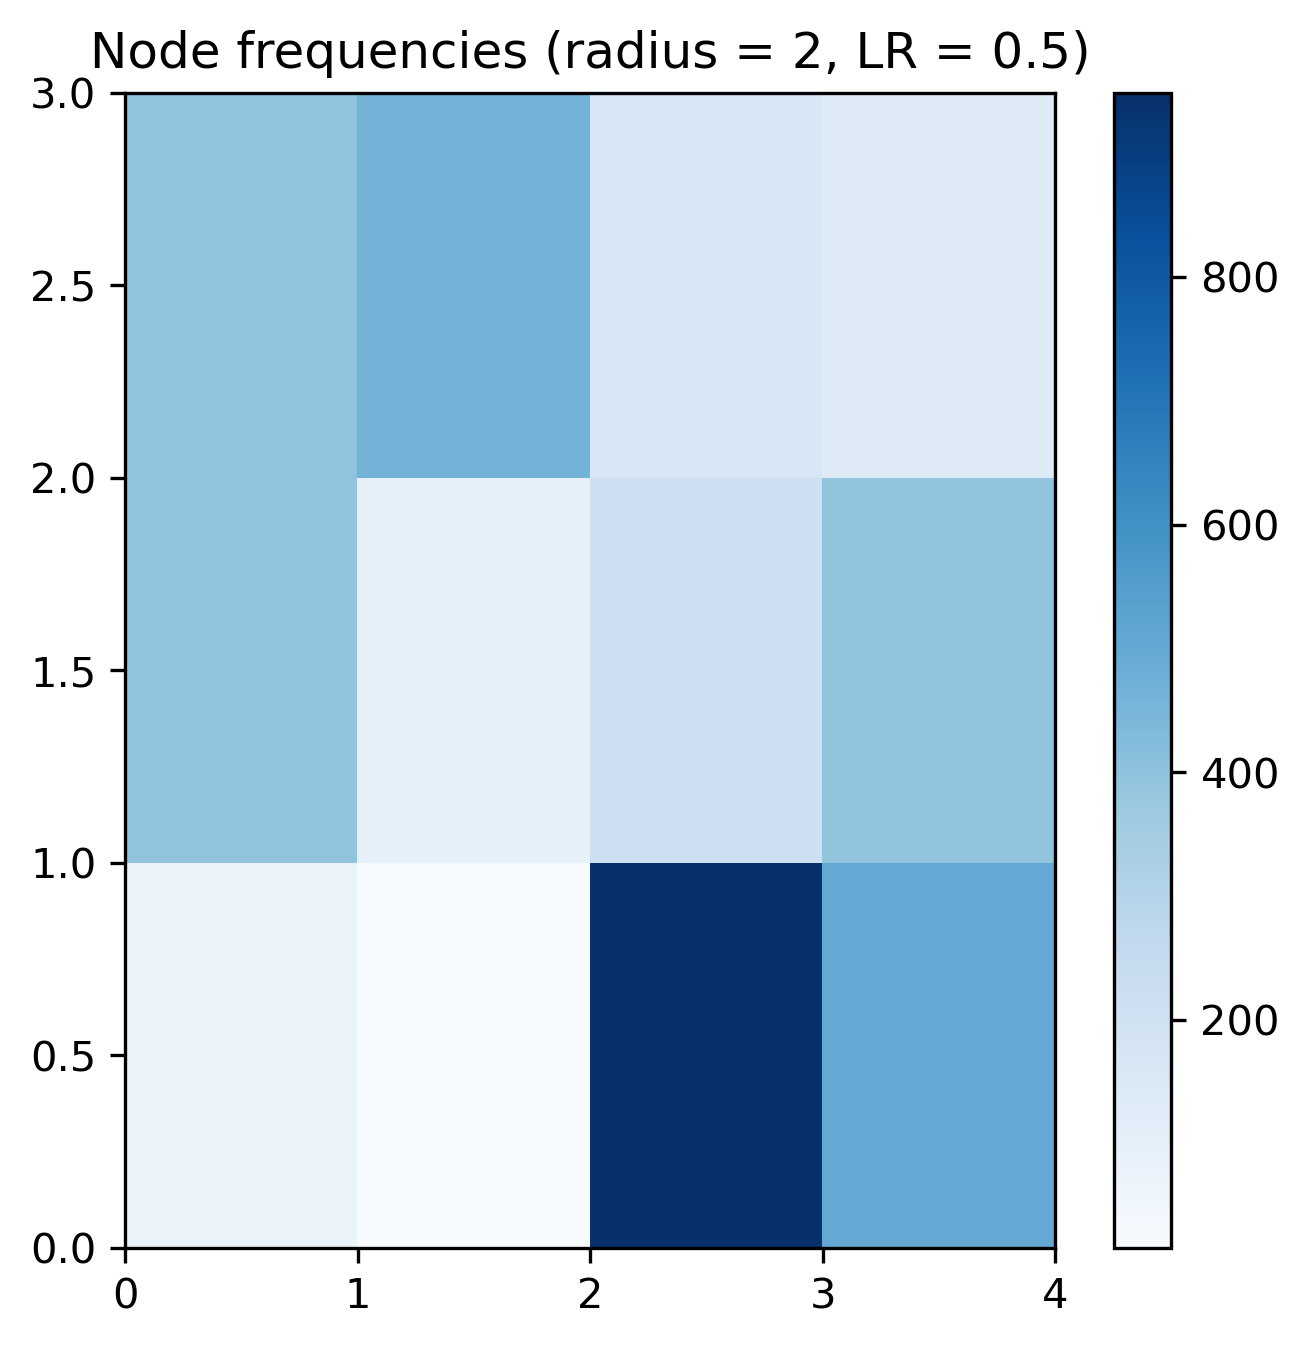

In [30]:
# Plot frequencies for each node
plt.figure(figsize=(5, 5),dpi=300)
frequencies = som.activation_response(all_data)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.title('Node frequencies (radius = '+str(sigma)+', LR = '+str(learning_rate)+')')
plt.savefig('node_freq.png')
plt.show()

In [31]:
win_maps = som.win_map(all_data)

In [33]:
win_maps_array = np.zeros(shape=(m*n,401*681))

k=0
for i in range(0,frequencies.shape[0]):
    for j in range(0,frequencies.shape[1]):
        print(i,j)
        win_map_mean = np.mean(win_maps[i,j], axis=0)
        win_maps_array[k]=win_map_mean[:-1]
        #win_maps_array[k]=win_map_mean
        k+=1

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2


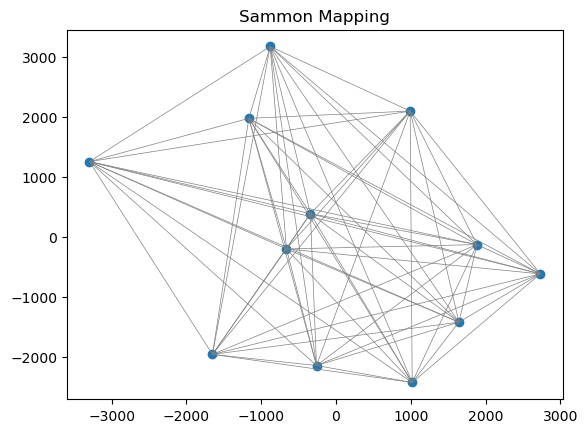

In [34]:
from sklearn.manifold import MDS

X = win_maps_array

# Apply Sammon mapping
mds = MDS(n_components=2, metric=True,normalized_stress='auto',dissimilarity='euclidean')
X_sammon = mds.fit_transform(X)

# Plot the results
import matplotlib.pyplot as plt

plt.scatter(X_sammon[:, 0], X_sammon[:, 1])

for i in range(X_sammon.shape[0]):
    for j in range(i + 1, X_sammon.shape[0]):
        plt.plot([X_sammon[i, 0], X_sammon[j, 0]], [X_sammon[i, 1], X_sammon[j, 1]], color='gray', linestyle='-', linewidth=0.5)

plt.title('Sammon Mapping')
plt.show()

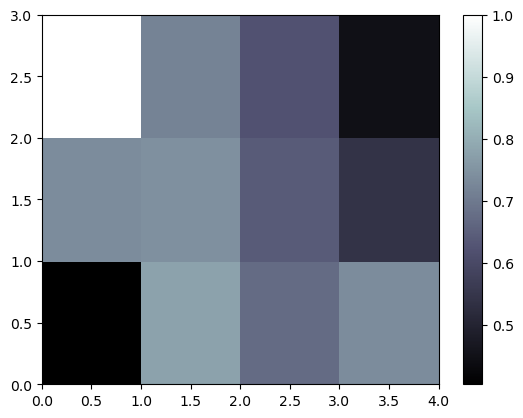

In [35]:
# Plot distances between each node and its neighbors
from pylab import plot,axis,show,pcolor,colorbar,bone
bone()
pcolor(som.distance_map(scaling='mean').T)
colorbar()

In [36]:
# Get euclidean distances between each node and its neighbors
# A mean euclidean distance closer to 1 indicates that the node patterns are different, a desired property of the SOM
distances = som.distance_map(scaling='mean')
distances.mean()

0.669326276868384

In [64]:
# Save daily maps associated with each node
for i in range(0,frequencies.shape[0]):
    for j in range(0,frequencies.shape[1]):
        print(i,j)
        # Calculate mean of all samples for each node
        if int(len(win_maps[i,j])) > 0:
            win_map_mean = np.mean(win_maps[i,j], axis=0)
    
            # Reshape into plottable format
            win_map = np.reshape(win_map_mean[:-1], (401,681), order = 'F')
            #win_map = np.reshape(win_map_mean, (401,681), order = 'F')
        
            np.save('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_'+str(i)+'_'+str(j)+'_labels.npy', win_map)

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2


In [38]:
# Save winning node location for each time step
winning_nodes = np.zeros(shape=(len(all_data),2))
i = 0
for n in range(0,len(all_data)):
    winning_nodes[i] = som.winner(all_data[n])
    i+=1

# You might want to save to a different path    
np.save('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/winning_nodes_labels.npy', winning_nodes)

In [39]:
winners=np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/winning_nodes_labels.npy')

In [40]:
winners_list = winners.tolist()

In [41]:
node_list = [[0.0,0.0],[0.0,1.0],[0.0,2.0],[1.0,0.0],[1.0,1.0],[1.0,2.0],[2.0,0.0],[2.0,1.0],[2.0,2.0],[3.0,0.0],[3.0,1.0],[3.0,2.0]]
mean_res_time = np.zeros(shape=[12])

i=0
for node in node_list:
    occurrences = []
    count=0
    for n in range(0,len(winners_list)):
        if winners_list[n] == node:
            pair = winners_list[n]
            if n > 0:
                if pair == winners_list[n-1]:
                    count+=1
                else:
                    count=1
                occurrences.append(count)
            else:
                count=1
            occurrences.append(count)
            
    mean_res_time[i] = round(np.mean(occurrences),3)
    print(np.max(occurrences))
    i+=1
        

7
19
12
6
5
15
15
6
8
20
10
10


In [42]:
mean_res_time

array([2.153, 3.345, 2.97 , 2.062, 1.687, 2.388, 3.392, 1.894, 1.84 ,
       3.241, 2.329, 2.588])

In [68]:
# Calculate mean pattern correlation between each node and its winning days
import scipy
node_list = [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2],[3,0],[3,1],[3,2]]
mean_pattern_corr = np.zeros(shape=(12))

k=0
for node in node_list:
    i,j = node
    corr_list = []
    for n in range(0,len(win_maps[i,j])):
        #bmu = np.mean(win_maps[i,j],axis=0)
        bmu = np.mean(win_maps[i,j][:-1],axis=0)
        bmu = bmu[:-1]
        day = win_maps[i,j][n]
        day = day[:-1]
        corr = scipy.stats.pearsonr(bmu, day)
        corr_list.append(corr.statistic)
    mean = np.mean(corr_list)
    mean_pattern_corr[k] = mean
    print(node, mean)
    k+=1
        

[0, 0] 0.6153410971676002
[0, 1] 0.43683530816475746
[0, 2] 0.3998657936577013
[1, 0] 0.6609750274204375
[1, 1] 0.5309678202626931
[1, 2] 0.3249943821617573
[2, 0] 0.2693633712517414
[2, 1] 0.3538446186771336
[2, 2] 0.39995813885684706
[3, 0] 0.3752863917379698
[3, 1] 0.3549003432412813
[3, 2] 0.4884212122589407


In [69]:
mean_pattern_corr.mean()

0.4342294587382385

In [70]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [71]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [72]:
# Load node patterns for plotting
node00 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_0_0_labels.npy')
node01 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_0_1_labels.npy')
node02 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_0_2_labels.npy')
node10 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_1_0_labels.npy')
node11 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_1_1_labels.npy')
node12 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_1_2_labels.npy')
node20 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_2_0_labels.npy')
node21 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_2_1_labels.npy')
node22 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_2_2_labels.npy')
node30 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_3_0_labels.npy')
node31 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_3_1_labels.npy')
node32 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_3_2_labels.npy')

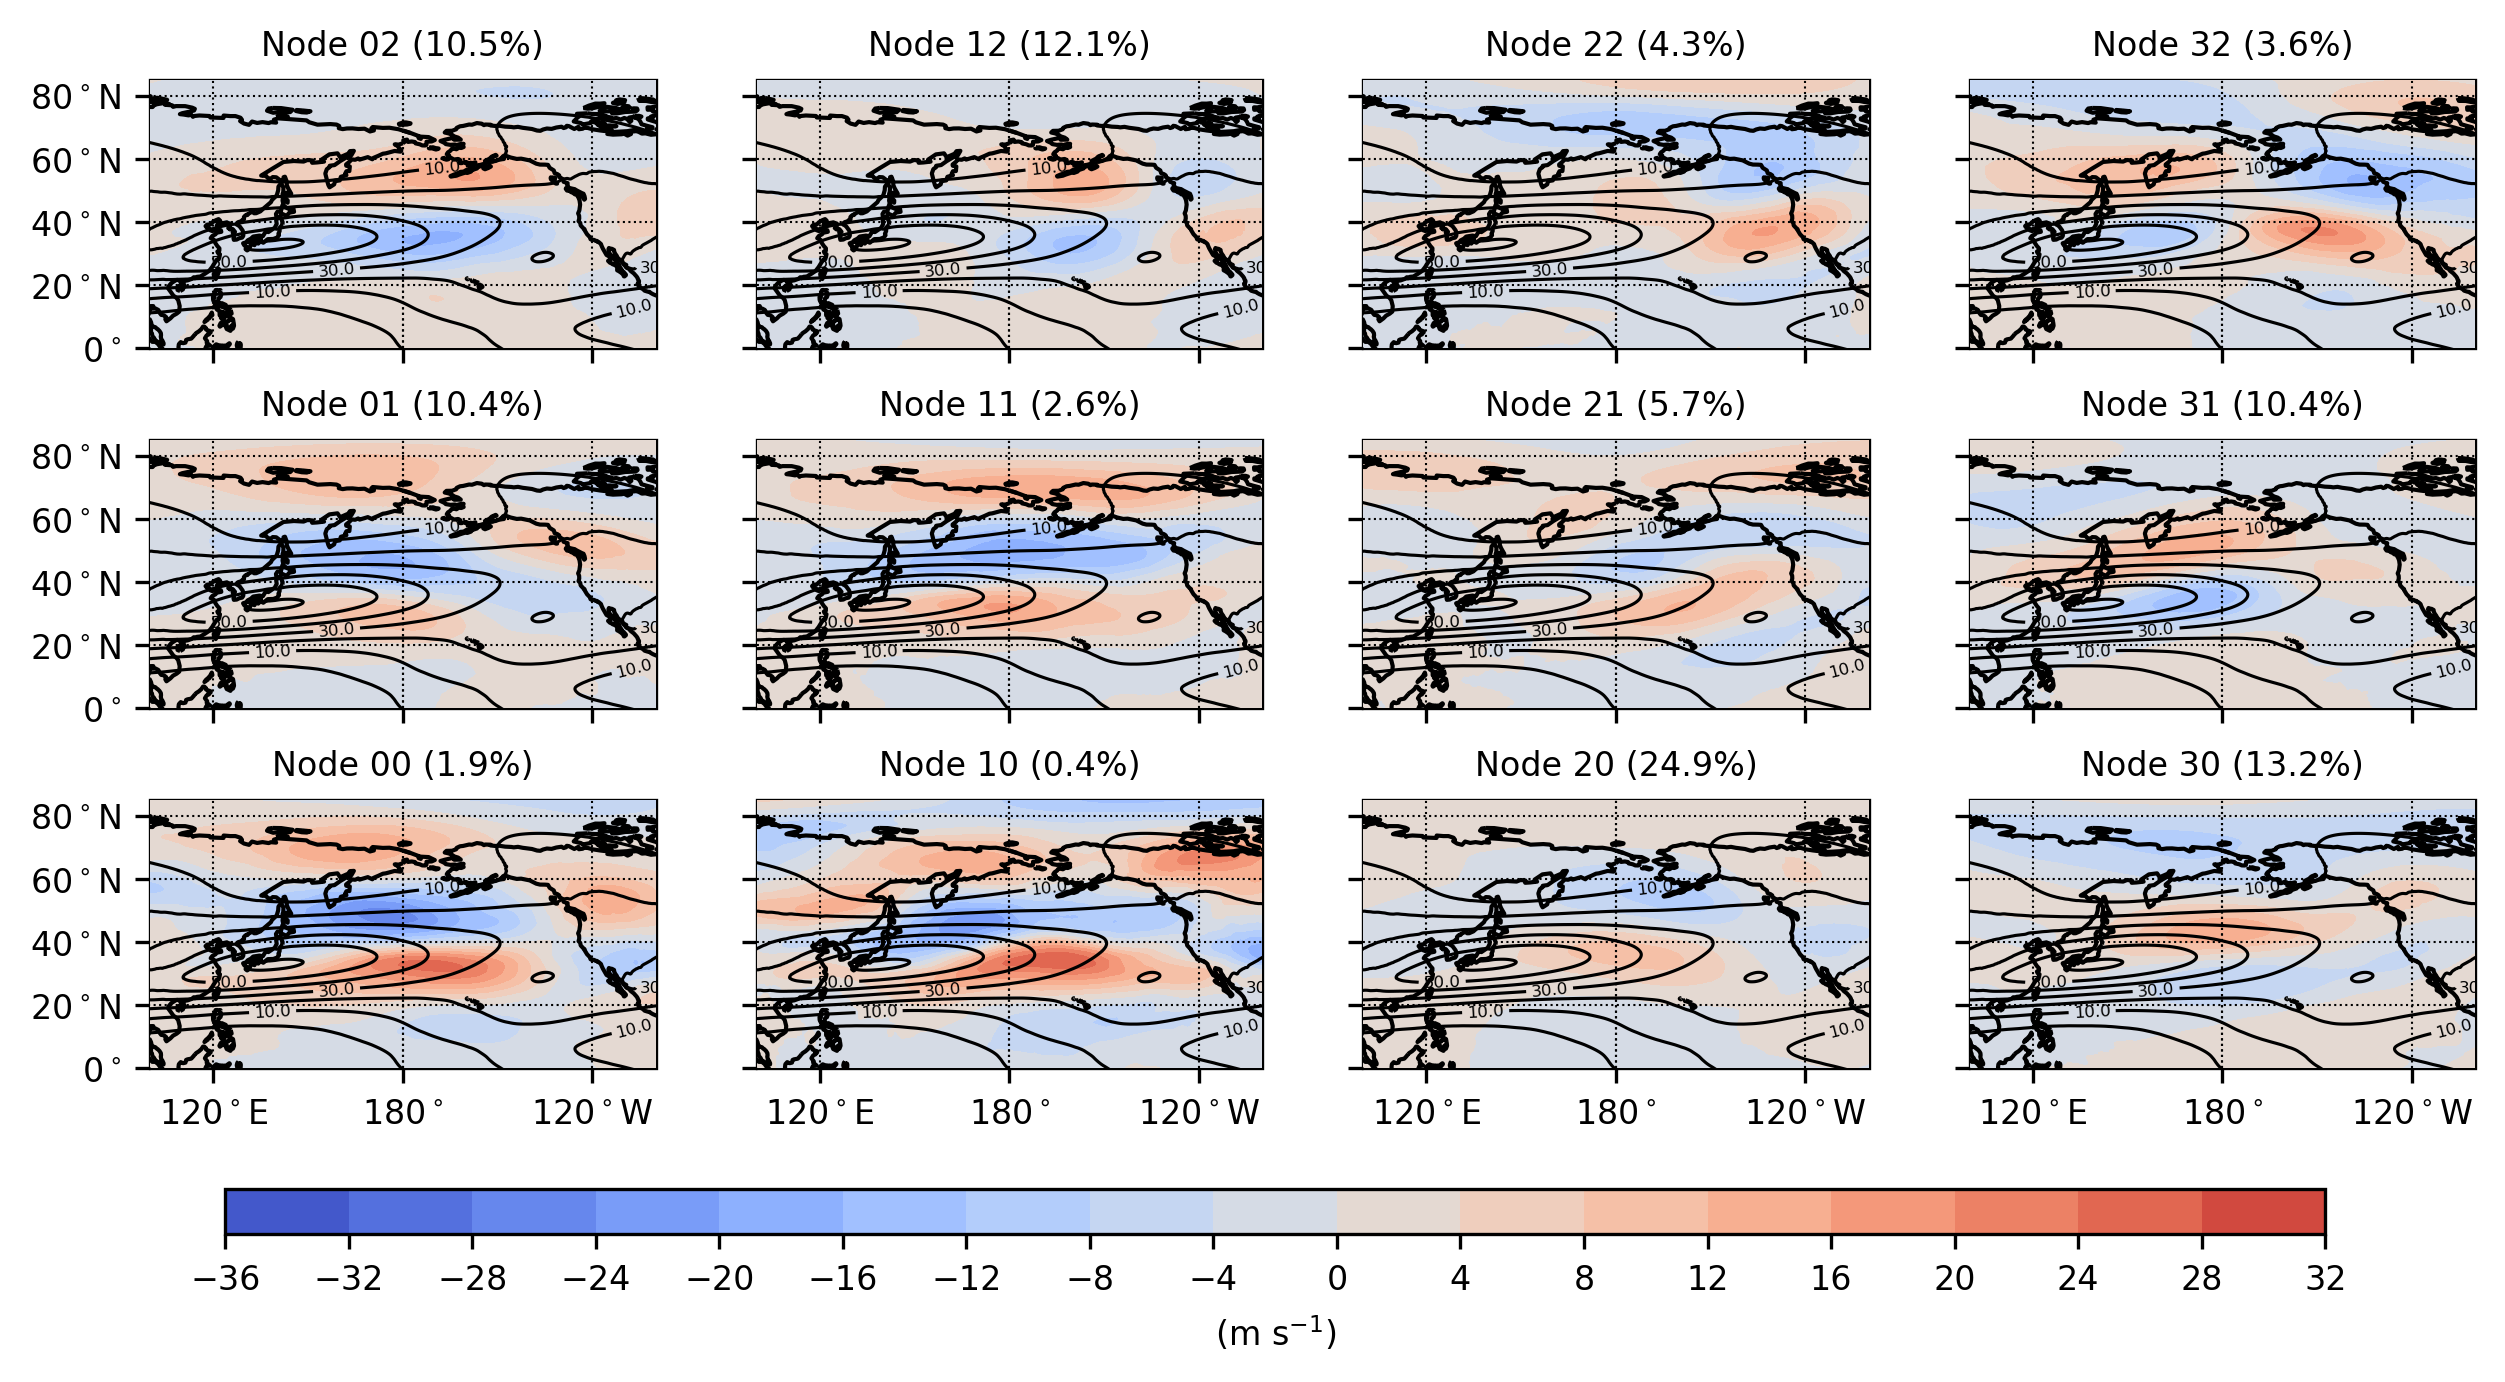

In [73]:
# Make figure
fig = plt.figure(figsize=(10,5), dpi=300)
data_crs = ccrs.PlateCarree()

central_lat = 15
central_lon = 210
extent = [100, 260, 0, 65]

size = 8
vmin = -36
vmax = 36
level = np.arange(vmin,vmax,4)

ax1 = plt.subplot(3,4,1,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax1.set_extent(extent)

land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m',
                                    facecolor=cfeature.COLORS['land'])
ocean = cfeature.NaturalEarthFeature(category='physical', name='ocean', scale='50m',
                                    facecolor='gray')

ax1.add_feature(ocean,zorder=1)
ax1.add_feature(land,zorder=2)

ct=ax1.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax1.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax1.contourf(lon,lat,node02,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax1, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax1.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax1.coastlines(zorder=5)
#ax1.set_xlabel("",size=size)
#ax1.set_ylabel("",size=size)
ax1.set_xticks(ticks = np.arange(-90, 60,60))
ax1.set_yticks(ticks = np.arange(0, 85,20))
ax1.set_yticklabels(labels = ['0$^\circ$','20$^\circ$N','40$^\circ$N','60$^\circ$N','80$^\circ$N'],size = size)
ax1.set_xticklabels(labels = ['','',''],size = size)
ax1.set_title('Node 02 ('+str(round(((frequencies[0,2]/len(all_data))*100),1))+'%)', size=size)


ax2 = plt.subplot(3,4,2,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax2.set_extent(extent)

ax2.add_feature(ocean,zorder=1)
ax2.add_feature(land,zorder=2)

ct=ax2.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax2.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax2.contourf(lon,lat,node12,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax2, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax2.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax2.coastlines(zorder=5)
#ax2.set_xlabel("",size=size)
#ax2.set_ylabel("",size=size)
ax2.set_xticks(ticks = np.arange(-90, 60,60))
ax2.set_yticks(ticks = np.arange(0, 85,20))
ax2.set_yticklabels(labels = ['','','','',''],size = size)
ax2.set_xticklabels(labels = ['','',''],size = size)
ax2.set_title('Node 12 ('+str(round(((frequencies[1,2]/len(all_data))*100),1))+'%)', size=size)


ax3 = plt.subplot(3,4,3,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax3.set_extent(extent)

ax3.add_feature(ocean,zorder=1)
ax3.add_feature(land,zorder=2)

ct=ax3.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax3.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax3.contourf(lon,lat,node22,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax3, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax3.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax3.coastlines(zorder=5)
#ax3.set_xlabel("",size=size)
#ax3.set_ylabel("",size=size)
ax3.set_xticks(ticks = np.arange(-90, 60,60))
ax3.set_yticks(ticks = np.arange(0, 85,20))
ax3.set_yticklabels(labels = ['','','','',''],size = size)
ax3.set_xticklabels(labels = ['','',''],size = size)
ax3.set_title('Node 22 ('+str(round(((frequencies[2,2]/len(all_data))*100),1))+'%)', size=size)


ax4 = plt.subplot(3,4,4,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax4.set_extent(extent)

ax4.add_feature(ocean,zorder=1)
ax4.add_feature(land,zorder=2)

ct=ax4.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax4.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax4.contourf(lon,lat,node32,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax4, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax4.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax4.coastlines(zorder=5)
#ax4.set_xlabel("",size=size)
#ax4.set_ylabel("",size=size)
ax4.set_xticks(ticks = np.arange(-90, 60,60))
ax4.set_yticks(ticks = np.arange(0, 85,20))
ax4.set_yticklabels(labels = ['','','','',''],size = size)
ax4.set_xticklabels(labels = ['','',''],size = size)
ax4.set_title('Node 32 ('+str(round(((frequencies[3,2]/len(all_data))*100),1))+'%)', size=size)


ax5 = plt.subplot(3,4,5,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax5.set_extent(extent)

ax5.add_feature(ocean,zorder=1)
ax5.add_feature(land,zorder=2)

ct=ax5.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax5.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax5.contourf(lon,lat,node01,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax5, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax5.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax5.coastlines(zorder=5)
#ax5.set_xlabel("",size=size)
#ax5.set_ylabel("",size=size)
ax5.set_xticks(ticks = np.arange(-90, 60,60))
ax5.set_yticks(ticks = np.arange(0, 85,20))
ax5.set_yticklabels(labels = ['0$^\circ$','20$^\circ$N','40$^\circ$N','60$^\circ$N','80$^\circ$N'],size = size)
ax5.set_xticklabels(labels = ['','',''],size = size)
ax5.set_title('Node 01 ('+str(round(((frequencies[0,1]/len(all_data))*100),1))+'%)', size=size)


ax6 = plt.subplot(3,4,6,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax6.set_extent(extent)

ax6.add_feature(ocean,zorder=1)
ax6.add_feature(land,zorder=2)

ct=ax6.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax6.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax6.contourf(lon,lat,node11,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax6, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax6.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax6.coastlines(zorder=5)
#ax6.set_xlabel("",size=size)
#ax6.set_ylabel("",size=size)
ax6.set_xticks(ticks = np.arange(-90, 60,60))
ax6.set_yticks(ticks = np.arange(0, 85,20))
ax6.set_yticklabels(labels = ['','','','',''],size = size)
ax6.set_xticklabels(labels = ['','',''],size = size)
ax6.set_title('Node 11 ('+str(round(((frequencies[1,1]/len(all_data))*100),1))+'%)', size=size)


ax7 = plt.subplot(3,4,7,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax7.set_extent(extent)

ax7.add_feature(ocean,zorder=1)
ax7.add_feature(land,zorder=2)

ct=ax7.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax7.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax7.contourf(lon,lat,node21,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax7, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax7.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax7.coastlines(zorder=5)
#ax7.set_xlabel("",size=size)
#ax7.set_ylabel("",size=size)
ax7.set_xticks(ticks = np.arange(-90, 60,60))
ax7.set_yticks(ticks = np.arange(0, 85,20))
ax7.set_yticklabels(labels = ['','','','',''],size = size)
ax7.set_xticklabels(labels = ['','',''],size = size)
ax7.set_title('Node 21 ('+str(round(((frequencies[2,1]/len(all_data))*100),1))+'%)', size=size)


ax8 = plt.subplot(3,4,8,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax8.set_extent(extent)

ax8.add_feature(ocean,zorder=1)
ax8.add_feature(land,zorder=2)

ct=ax8.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax8.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax8.contourf(lon,lat,node31,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax8, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax8.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax8.coastlines(zorder=5)
#ax8.set_xlabel("",size=size)
#ax8.set_ylabel("",size=size)
ax8.set_xticks(ticks = np.arange(-90, 60,60))
ax8.set_yticks(ticks = np.arange(0, 85,20))
ax8.set_yticklabels(labels = ['','','','',''],size = size)
ax8.set_xticklabels(labels = ['','',''],size = size)
ax8.set_title('Node 31 ('+str(round(((frequencies[3,1]/len(all_data))*100),1))+'%)', size=size)


ax9 = plt.subplot(3,4,9,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax9.set_extent(extent)

ax9.add_feature(ocean,zorder=1)
ax9.add_feature(land,zorder=2)

ct=ax9.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax9.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax9.contourf(lon,lat,node00,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax9, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax9.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax9.coastlines(zorder=5)
#ax9.set_xlabel("",size=size)
#ax9.set_ylabel("",size=size)
ax9.set_xticks(ticks = np.arange(-90, 60,60))
ax9.set_yticks(ticks = np.arange(0, 85,20))
ax9.set_yticklabels(labels = ['0$^\circ$','20$^\circ$N','40$^\circ$N','60$^\circ$N','80$^\circ$N'],size = size)
ax9.set_xticklabels(labels = ['120$^\circ$E','180$^\circ$','120$^\circ$W'],size = size)
ax9.set_title('Node 00 ('+str(round(((frequencies[0,0]/len(all_data))*100),1))+'%)', size=size)


ax10 = plt.subplot(3,4,10,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax10.set_extent(extent)

ax10.add_feature(ocean,zorder=1)
ax10.add_feature(land,zorder=2)

ct=ax10.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax10.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax10.contourf(lon,lat,node10,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax10, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax10.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax10.coastlines(zorder=5)
#ax10.set_xlabel("",size=size)
#ax10.set_ylabel("",size=size)
ax10.set_xticks(ticks = np.arange(-90, 60,60))
ax10.set_yticks(ticks = np.arange(0, 85,20))
ax10.set_yticklabels(labels = ['','','','',''],size = size)
ax10.set_xticklabels(labels = ['120$^\circ$E','180$^\circ$','120$^\circ$W'],size = size)
ax10.set_title('Node 10 ('+str(round(((frequencies[1,0]/len(all_data))*100),1))+'%)', size=size)


ax11 = plt.subplot(3,4,11,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax11.set_extent(extent)

ax11.add_feature(ocean,zorder=1)
ax11.add_feature(land,zorder=2)

ct=ax11.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax11.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax11.contourf(lon,lat,node20,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax11, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax11.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax11.coastlines(zorder=5)
#ax11.set_xlabel("",size=size)
#ax11.set_ylabel("",size=size)
ax11.set_xticks(ticks = np.arange(-90, 60,60))
ax11.set_yticks(ticks = np.arange(0, 85,20))
ax11.set_yticklabels(labels = ['','','','',''],size = size)
ax11.set_xticklabels(labels = ['120$^\circ$E','180$^\circ$','120$^\circ$W'],size = size)
ax11.set_title('Node 20 ('+str(round(((frequencies[2,0]/len(all_data))*100),1))+'%)', size=size)


ax12 = plt.subplot(3,4,12,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax12.set_extent(extent)

ax12.add_feature(ocean,zorder=1)
ax12.add_feature(land,zorder=2)

ct=ax12.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax12.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax12.contourf(lon,lat,node30,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax12, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax12.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax12.coastlines(zorder=5)
#ax12.set_xlabel("",size=size)
#ax12.set_ylabel("",size=size)
ax12.set_xticks(ticks = np.arange(-90, 60,60))
ax12.set_yticks(ticks = np.arange(0, 85,20))
ax12.set_yticklabels(labels = ['','','','',''],size = size)
ax12.set_xticklabels(labels = ['120$^\circ$E','180$^\circ$','120$^\circ$W'],size = size)
ax12.set_title('Node 30 ('+str(round(((frequencies[3,0]/len(all_data))*100),1))+'%)', size=size)


fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.03])
cbar = fig.colorbar(contf, cax=cbar_ax, ticks = np.arange(vmin, vmax, 4), orientation='horizontal', shrink = 0.60, pad = 0.0)
cbar.set_label('(m s$^{-1}$)',fontsize=size)
cbar.ax.tick_params(labelsize=size)

plt.savefig('node_patterns.png')
plt.show()
